# Reanalysis of Dispersion Measure Periodicity for Fast Radio Bursts and Perytons

# A Blog post and Open Notebook

### Inspired by Hippke et al. (2015), http://arxiv.org/pdf/1503.05245v2.pdf. An earlier iteration on this notebook was published as Dinah review at http://dinah-peer-review.appspot.com.

Primary motivating questions:
* Is there a significant "periodicity" in the dispersion measures of FRBs?
* Are there shared properties (particularly dispersion measure) between Perytons and FRBs?

tl;dr:
* Analysis with FRB DMs as of November 2015 shows that whatever small significance for periodicity in the DM distribution has totally disappeared.
* This notebook is available as a "binder", a tool for reproducible science. TTBB and can be mybinder.org


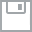
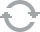
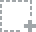
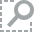
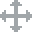
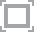
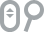
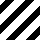
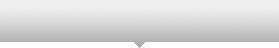
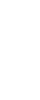
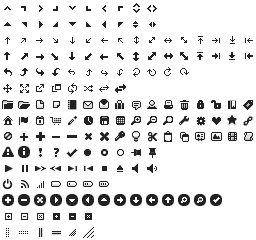
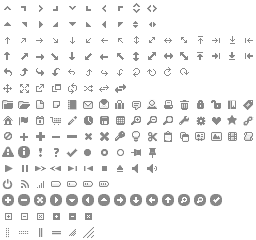
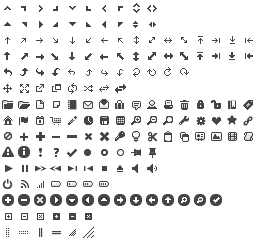
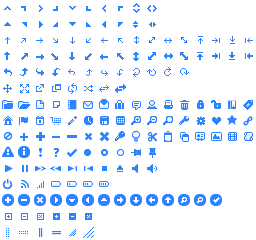
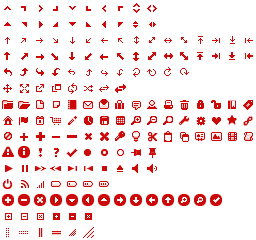
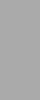
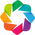
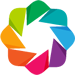

In [34]:
import numpy as n
import os, glob
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, gridplot
from bokeh.charts.utils import cycle_colors
output_notebook()

## Define and Generate Dispersion Measure distributions

* DMfrb is all known FRBs (starting with Hippke et al. sample)
* FRB detection papers included: Lorimer, Thornton, Spitler, Petroff, Keane & Stappers, Ravi, Burke-Spolaor & Bannister, Champion, Masui (GBT detection; not yet published)
* DMper is observed (17) Perytons
* dmr1 is random with max of 1000 pc/cm3
* dmr2 is random with mean/std equal to that of observed FRBs

In [35]:
dmfrb = n.array([  375. ,   553.3,   557.4,   562.7,   723. ,   746. ,   788. ,     790. ,   944.4,  1103.6, 899.6, 1629.2, 952.4, 469.9, 861, 623.3])  # FRB DMs
dmper = n.array([344, 400, 382, 217, 213, 396, 421, 357, 393, 374, 278, 402, 400, 350, 350, 350, 375])      # Peryton DMs

# random values
dmmax = max(dmfrb.max(), dmper.max())
dmr1 = n.random.rand(1000)*dmmax
dmr2 = n.random.normal(dmfrb.mean(), dmfrb.std(), 1000)

In [36]:
print len(dmfrb), len(dmper), len(dmr1), len(dmr2)

16 17 1000 1000


## Define useful functions for calculating random DM distributions and their cumulative distribution properties

### Here we use a Rayleigh test (in "inttrial" function) to calculate significance of "periodicity" or integer multiples

In [37]:
def cdist(dmlist, returnplot=False, h=400, w=800, tools='pan, wheel_zoom, reset', label=True, legendlist=[]):
    """ Plot cumulative distribution
    dmlist is list of dm arrays.
    """
    
    assert len(dmlist[0]), 'Need data to plot.'
    
    p = figure(plot_width=w, plot_height=h, tools=tools)
    if label:
        p.xaxis.axis_label = 'DM (pc/cm3)'
        p.xaxis.axis_label = 'Cumulative fraction'

    colors = cycle_colors(dmlist)
    for i in range(len(dmlist)):
        dms = dmlist[i]
        count = len(dms)
        cfrac = n.arange(1,count+1)/float(count)
        dms.sort()
        try:
            legend = legendlist[i]
        except IndexError:
            legend=''
        p.scatter(dms, cfrac, legend=legend, line_color=colors[i], fill_color=None)
    if not returnplot:
        show(p)
    else:
        return p
        
def inttrial(dms, dmmin=0, dmmax=0):
    """ For a given sample of DMs, find residual for a set of assumed fundamental integer DM basis
    """

    modulo = lambda dm: (n.mod(dms, dm)/dm).mean()
    ray = lambda dm: n.sqrt(n.sin(2*n.pi*dms/dm).mean()**2 + n.cos(2*n.pi*dms/dm).mean()**2)
    ray2 = lambda dm: 1./len(dms) * ( (n.sin(2*n.pi*dms/dm).sum())**2 + (n.cos(2*n.pi*dms/dm).sum())**2 )  # includes scaling with number of events

    if dmmin == 0:
        dmmin = dms.max()/float(len(dms))
    if dmmax == 0:
        dmmax = dms.max()/2
    stat = []
    grid = n.arange(dmmin,dmmax,0.5)
    for dm in grid:
#        stat.append(modulo(dm, dms))  # alternate statistic
        stat.append(ray(dm))
    return n.array(grid), n.array(stat)

def plottrial(triallist, legendlist=[]):
    """
    """
    
    assert len(triallist[0]) == 2, 'Need at least one pair of dms/stat.'
    colors = cycle_colors(triallist)

    p = figure(plot_width=800, plot_height=400)
    p.xaxis.axis_label = 'Assumed Fundamental DM (pc/cm3)'
    p.yaxis.axis_label = 'Statistic'
    for i in range(len(triallist)):
        (grid,resid) = triallist[i]
        try:
            legend = legendlist[i]
        except IndexError:
            legend=''

        p.scatter(grid, resid, legend=legend, line_color=colors[i], fill_color=None)
    show(p)
    
def sample(dms, ntrials, size=10, thresh=0, dmmin=0, dmmax=0):
    """ Sample dms ntrials times with size values and calculate inttrial distribution.
    Minimum of inttrial distribution saved.
    """

    minresid = []
    dmresid = []
    lowesttrial = []; lowestdms = []
    for i in range(ntrials):
        sampleints = n.random.random_integers(0, len(dms)-1, size)
        dmsample = dms.take(sampleints)
        grid, resid = inttrial(dmsample, dmmin=dmmin, dmmax=dmmax)
#        minresid.append(resid.min())
#        dmresid.append(grid[n.where(resid == resid.min())])
#        if (thresh > 0) and (resid.min() < thresh):
        minresid.append(resid.max())
        dmresid.append(grid[n.where(resid == resid.max())])
        if (thresh > 0) and (resid.max() > thresh):
            lowesttrial.append((grid, resid))
            lowestdms.append(dmsample)
    if thresh > 0:
        print 'Found %d out of %d. Occurrence rate of %.3f beyond threshold Rayleigh test statistic value.' % (len(lowesttrial), ntrials, len(lowesttrial)/float(ntrials))
    return n.array(dmresid).flatten(), n.array(minresid), lowesttrial, lowestdms

## Visualize observed and simulated DM cumulative distributions

In [38]:
# cumulative distributions of all four full samples
cdist([dmfrb, dmper, dmr1, dmr2], legendlist=['DMfrb', 'DMper', 'DMr1', 'DMr2'])

## What is the value of the Rayleigh test statistic for each of the distributions above in their entirety?

In [46]:
# fundamental DM trials analysis for all four full samples
plottrial([inttrial(dmfrb), inttrial(dmper), inttrial(dmr1), inttrial(dmr2)], legendlist=['DMfrb', 'DMper', 'DMr1', 'DMr2'])

## Using published FRB DM distribution, calculate Rayleigh test statistic

In [40]:
grid, resid = inttrial(dmfrb)
thresh = resid.max()
dmpeak = grid[n.where(resid == thresh)]
print 'FRBs Rayleigh test value:', thresh, dmpeak[0]
grid, resid = inttrial(dmper)
print 'Perytons Rayleigh test value:', resid.max(), grid[n.where(resid == resid.max())][0]

FRBs Rayleigh test value: 0.46635404939 178.325
Perytons Rayleigh test value: 0.615273887653 184.764705882


In [41]:
p = figure(plot_height=400, plot_width=800, x_range=(0,2000), y_range=(-0.5,0.5))
#axis( (0, 1200, -1, 1) )
yval = n.random.normal(-0.25, 0.05, len(dmper))
p.circle(dmper, yval, legend='Perytons', fill_color=None)
#p.text(30, -0.75, "Perytons", verticalalignment='center', horizontalalignment='left', fontsize=20)
yval = n.random.normal(0.25, 0.05, len(dmfrb))
p.cross(dmfrb, yval, legend='FRBs')
#p.text(30, 0.75, "FRBs", verticalalignment='center', horizontalalignment='left', fontsize=20)
p.xaxis.axis_label = 'DM/DMeff'
p.yaxis.axis_label = 'Arb'
show(p)

## How often does this Rayleigh test value occur in a random samples of 10 events (as for true FRB sample)?

In [42]:
dmresid, resid, lowesttrial, lowestdms = sample(dmr1, 100, size=len(dmfrb), thresh=thresh)

Found 69 out of 100. Occurrence rate of 0.690 beyond threshold Rayleigh test statistic value.


## How common is it to have a very small residual DM, if assuming a fundamental DM?

In [43]:
p = figure(plot_height=400, plot_width=800)
p.scatter(dmresid, resid, fill_color=None)
p.xaxis.axis_label = 'DM at minimum residual'
p.yaxis.axis_label = 'Min residual for a given trial'
show(p)

## What is the cumulative DM distribution for these simulated samples with "significant" periodicities?

In [48]:
len(lowestdms[0])

16

In [50]:
pl = []
width = 4
for i in range(0, len(lowestdms), width):
    pl2 = []
    for j in range(width):
        try:
            pl2.append(cdist([lowestdms[i+j]], h=200, w=200, tools='', label=False, returnplot=True))
        except:
            pass
    pl.append(pl2)

# append two final plots of actual FRB and Peryton DM distributions
pl.append([cdist([dmfrb], h=200, w=200, tools='', label=False, returnplot=True), None, None, None])
pl.append([cdist([dmper], h=200, w=200, tools='', label=False, returnplot=True), None, None, None])

p = gridplot(pl)
show(p)